Ref: https://nextjournal.com/gkoehler/pytorch-mnist

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt

In [3]:
n_epochs = 3
# why not the same? Why test so big?
batch_size_train = 512
batch_size_test = 512*2
learning_rate = 0.01
#momentum = 0.5
# what is this?
#log_interval = 10

# random_seed = 1
# torch.backends.cudnn.enabled = False
# torch.manual_seed(random_seed)

## Load data

In [4]:
# download and get data
train_ds = torchvision.datasets.MNIST('./datasets', train=True, download=True,
                             transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))]))
test_ds = torchvision.datasets.MNIST('./datasets', train=False, download=True,
                             transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))]))
# load data to dataloader
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size_test, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 117824280.44it/s]


Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 27480874.28it/s]


Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 30411553.57it/s]


Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4220320.95it/s]

Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



In [5]:
# x is input, y is label
x, y = next(iter(train_loader))
print(x.shape, y.shape, x.min(), x.max())

torch.Size([512, 1, 28, 28]) torch.Size([512]) tensor(-0.4242) tensor(2.8215)


In [6]:
type(x)

torch.Tensor

In [7]:
# the number of batches
len(train_loader)

118

In [8]:
# train_loader is a DataLoader object, containing 938 'sub-object' which are iterable. Note: 60000 images in total. 60000//64 = 938!
# Each 'sub-obj' consists of 2 torch.Tensor objects: [inputs, labels].
# Inputs are 64*1*28*28, labels are 1d vector, len = 64.

## utils

In [9]:
def plot_curve(data):
    fig = plt.figure()
    plt.plot(range(len(data)), data, color='blue')
    plt.legend(['value'], loc='upper right')
    plt.xlabel('step')
    plt.ylabel('value')
    plt.show()



def plot_image(img, label, name):

    fig = plt.figure()
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.tight_layout()
        plt.imshow(img[i][0]*0.3081+0.1307, cmap='gray', interpolation='none')
        plt.title("{}: {}".format(name, label[i].item()))
        plt.xticks([])
        plt.yticks([])
    plt.show()


def one_hot(label, depth=10):
    out = torch.zeros(label.size(0), depth)
    idx = torch.LongTensor(label).view(-1, 1)
    # scatter don't know...
    out.scatter_(dim=1, index=idx, value=1)
    return out

## Visualized data

Currently didn't fully understand...

torch.Size([512, 1, 28, 28]) torch.Size([512]) tensor(-0.4242) tensor(2.8215)


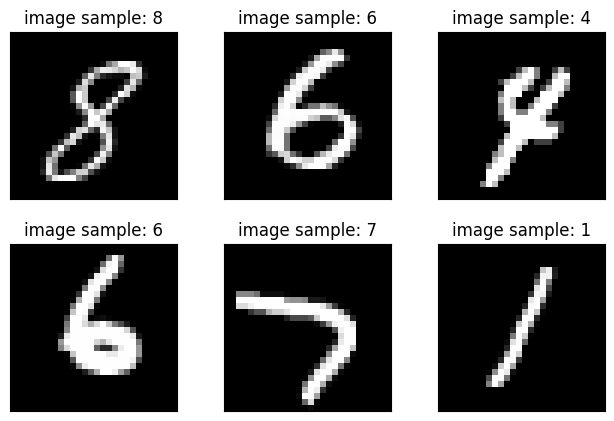

In [10]:
x, y = next(iter(train_loader))
print(x.shape, y.shape, x.min(), x.max())
plot_image(x, y, 'image sample')

## Build network

In [11]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        # xw+b
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        # x: [b, 1, 28, 28]
        # h1 = relu(xw1+b1)
        x = F.relu(self.fc1(x))
        # h2 = relu(h1w2+b2)
        x = F.relu(self.fc2(x))
        # h3 = h2w3+b3
        x = self.fc3(x)

        return x

In [13]:
network = Net()
# parameters: [w1, b1, w2, b2, w3, b3]
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.9)

epoch: 0, batch_idx: 0, loss: 0.03483414649963379
epoch: 1, batch_idx: 0, loss: 0.03123641014099121
epoch: 2, batch_idx: 0, loss: 0.027510514482855797


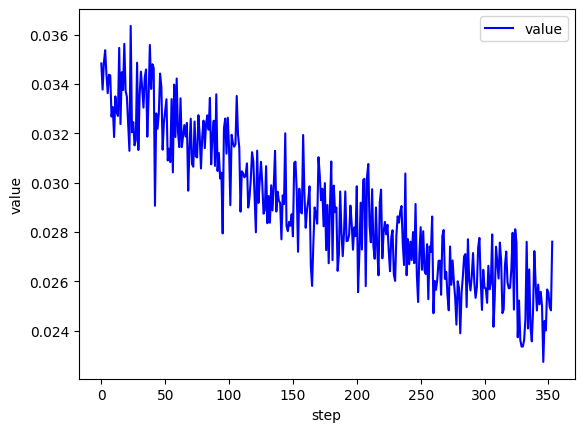

In [16]:
train_loss = []

for epoch in range(3):

    for batch_idx, (x, y) in enumerate(train_loader):

        # x: [batch_size, 1, 28, 28], y: [batch_size]
        # [batch_size, 1, 28, 28] => [batch_size, 784]
        x = x.reshape(x.size(0), 28*28)
        # out(predicted results) shape: [batch_size, 10]
        out = network(x)

        # labels shape: [batch_size] -> [batch_size, 10]
        # one hot makes the shape the same as predicted results!
        y_onehot = one_hot(y)
        # loss = mse(out, y_onehot)
        loss = F.mse_loss(out, y_onehot)
        # clear accumulated grad to 0
        optimizer.zero_grad()
        # backward propogation
        loss.backward()
        # update parameters: w' = w - lr*grad
        optimizer.step()
        # record loss
        train_loss.append(loss.item())

        if batch_idx % 200==0:
            print(f"epoch: {epoch}, batch_idx: {batch_idx}, loss: {loss.item()}")

plot_curve(train_loss)
# we get optimal [w1, b1, w2, b2, w3, b3]

test acc: 0.914


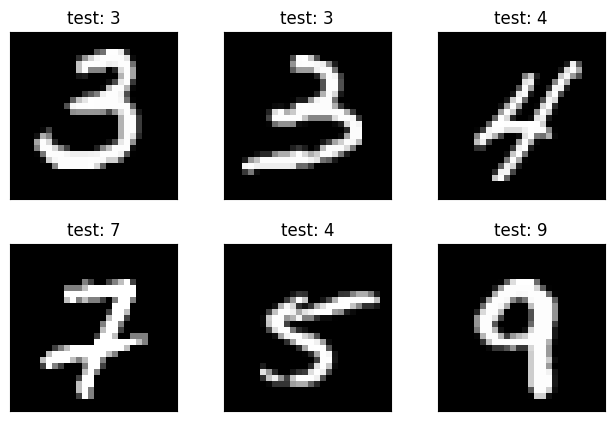

In [18]:
total_correct = 0
for x,y in test_loader:
    x  = x.reshape(x.size(0), 28*28)
    out = network(x)
    # out: [b, 10] => pred: [b]
    pred = out.argmax(dim=1)
    correct = pred.eq(y).sum().float().item()
    total_correct += correct

total_num = len(test_loader.dataset)
acc = total_correct / total_num
print('test acc:', acc)

x, y = next(iter(test_loader))
out = network(x.view(x.size(0), 28*28))
pred = out.argmax(dim=1)
plot_image(x, pred, 'test')